# Prediction of S&P500 index change using technical analysis and Machine Learning

## Project Overview:

The S&P500, which includes 500 of the largest companies listed on the stock market in the United States, represents a broad cross-section of the U.S. equity market. The primary aim of this project was to build a machine learning classifier capable of will tomorrow sesion will end with significant up or down. Importence of movement is based on historical daily returns.

**Why classification not regression?**

While it may seem like setting this up as a regression problem (predicting where the price will be) I recognized that, according to the random walk hypothesis, not every move is worth tracking. Therefore, I chose to classify them as either a significant decline (1) or a significant increase (2). On the other hand, everything in between is considered random walk (value 0) and not worth trading.


## Install yahoo finance and ta library

In [20]:
!pip install yahoo-finance
!pip install ta

## Imports

In [21]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
#import libriaries
import yfinance as yf
import numpy as np
import pandas as pd
#scaler, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# machine learning models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#technical analysis
from ta import add_all_ta_features
#pipeline
from sklearn.pipeline import Pipeline
#PCA
from sklearn.decomposition import PCA
# Statistics
from statsmodels.tsa.stattools import adfuller
# models validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
#visualization
import matplotlib.pyplot as plt

## Download data from yahoo finance (yf)

In [22]:
sp = yf.Ticker("ES=F")
hist = sp.history(period='13y')
df=hist.drop(columns={'Dividends','Stock Splits'})
df=df.dropna()
df

,Open,High,Low,Close,Volume
Date,,,,,
2010-07-19 00:00:00-04:00,1061.75,1071.00,1057.00,1063.75,1760879
2010-07-20 00:00:00-04:00,1063.25,1080.75,1050.75,1080.00,2275816
2010-07-21 00:00:00-04:00,1079.50,1087.75,1061.00,1064.00,2440958
2010-07-22 00:00:00-04:00,1063.25,1094.50,1061.25,1087.75,2178892
2010-07-23 00:00:00-04:00,1087.25,1101.50,1084.00,1100.50,2091081
...,...,...,...,...,...
2023-07-12 00:00:00-04:00,4471.00,4523.75,4470.00,4507.50,1784296
2023-07-13 00:00:00-04:00,4510.50,4551.50,4509.25,4543.50,1158193
2023-07-14 00:00:00-04:00,4539.50,4560.50,4531.00,4536.75,1381069


Look at chart of Close price because based on it we will create return values

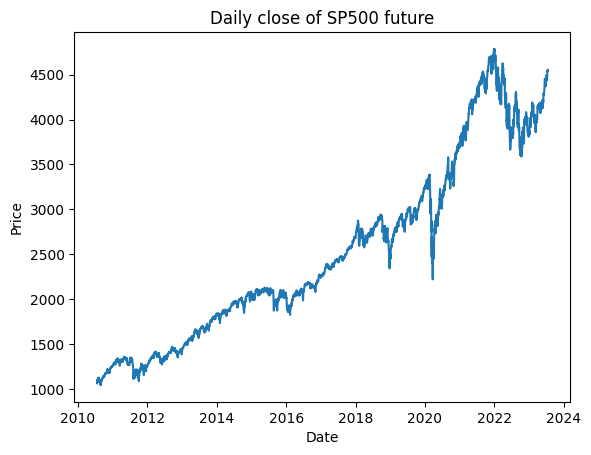

In [23]:
plt.plot(df.index,df['Close'])
plt.title('Daily close of SP500 future')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Doesn't look like a stationary data. But look also at the histogram of these values.

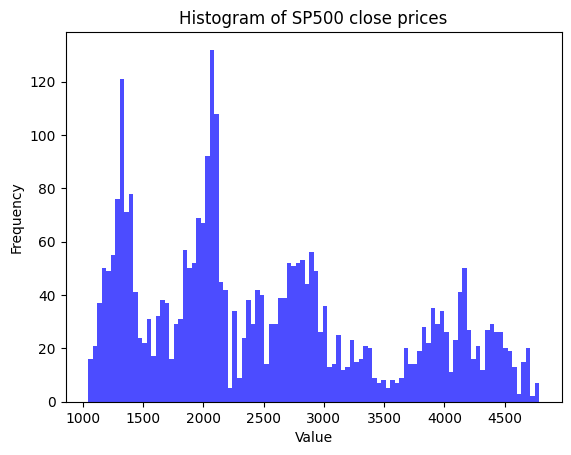

In [24]:
df['Close'].hist(bins=100, grid=False, color='blue', alpha=0.7)
plt.title('Histogram of SP500 close prices')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Closing prices of S&P500 futures are definitely non-stationary data.

## Technical analysis

Technical analysis is a method people use to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume. Instead of looking at the company's details like its financial health or products, they look at charts of price movement and various analytical tools to evaluate a security's strength or weakness. It can be used also for indicies or currencies trading. One of the rules of technical analysis says that the price already contains everything (the hopes and fears of investors). So, theoretically, using technical analysis alone, it should be possible to predict the price.

In [25]:
#adding all technical features from ta library
df_ = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
# looking at new df
df_.head()

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-19 00:00:00-04:00,1061.75,1071.00,1057.00,1063.75,1760879,-6.288854e+04,1760879,-0.035714,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1063.750000,-57.856057,0.000000,0.000000
2010-07-20 00:00:00-04:00,1063.25,1080.75,1050.75,1080.00,2275816,2.099137e+06,4036695,0.520014,3.698201e+07,2306.864878,...,0.121723,0.024345,0.097379,2.283329,0.456666,1.826663,1070.466819,1.527615,1.516064,1.527615
2010-07-21 00:00:00-04:00,1079.50,1087.75,1061.00,1064.00,2440958,2.056833e+05,1595737,0.031753,2.611953e+07,9451.975413,...,0.095859,0.038648,0.057212,4.655461,1.296425,3.359036,1067.811366,-1.481481,-1.492565,0.023502
2010-07-22 00:00:00-04:00,1063.25,1094.50,1061.25,1087.75,2178892,1.499912e+06,3774629,0.173269,2.978084e+07,5341.017361,...,0.252011,0.081320,0.170690,5.304147,2.097969,3.206178,1075.842216,2.232143,2.207595,2.256169
2010-07-23 00:00:00-04:00,1087.25,1101.50,1084.00,1100.50,2091081,3.352013e+06,5865710,0.311884,2.933519e+07,12448.704761,...,0.465862,0.158228,0.307633,5.378740,2.754123,2.624616,1085.797308,1.172144,1.165328,3.454759


## Features engineering

Some of the columns may be also considered as a non-stationary data. So let's find out how many are them using adfuller.

In [26]:
# Identify non-stationary columns
non_stationaries = []
for col in df_.columns:
    dftest = adfuller(df_[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 31


There is 91 features and 31 of them are non-stationary. Let's change them to stationary with .pct_change() method.

In [27]:
# Convert non-stationaries to stationary
df_stationary = df_.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
# Lets start from second row, becouse first one is full of NaNs
df_stationary = df_stationary.iloc[1:]
# take a look at our data
df_stationary.head()

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-20 00:00:00-04:00,0.001413,0.009104,-0.005913,0.015276,2275816,-34.378686,1.292432,0.520014,3.698201e+07,2306.864878,...,0.121723,0.024345,0.097379,2.283329,0.456666,1.826663,0.006314,1.527615,1.516064,inf
2010-07-21 00:00:00-04:00,0.015283,0.006477,0.009755,-0.014815,2440958,-0.902015,-0.604692,0.031753,2.611953e+07,9451.975413,...,0.095859,0.038648,0.057212,4.655461,1.296425,3.359036,-0.002481,-1.481481,-1.492565,-0.984615
2010-07-22 00:00:00-04:00,-0.015053,0.006205,0.000236,0.022321,2178892,6.292340,1.365446,0.173269,2.978084e+07,5341.017361,...,0.252011,0.081320,0.170690,5.304147,2.097969,3.206178,0.007521,2.232143,2.207595,95.000000
2010-07-23 00:00:00-04:00,0.022572,0.006396,0.021437,0.011721,2091081,1.234806,0.553983,0.311884,2.933519e+07,12448.704761,...,0.465862,0.158228,0.307633,5.378740,2.754123,2.624616,0.009253,1.172144,1.165328,0.531250
2010-07-26 00:00:00-04:00,0.012877,0.009305,0.011993,0.008178,1543914,0.320073,0.263210,0.359996,2.712948e+07,11106.107594,...,0.693777,0.265338,0.428439,3.141567,2.831612,0.309955,0.008891,0.817810,0.814484,0.244898


Some of these columns may have NaN values or infinity (inf/-inf). Let's clean our data set.

In [28]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

<ipython-input-28-fc795c82aa66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stationary.drop(columns=na_list, inplace=True)
<ipython-input-28-fc795c82aa66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stationary.replace([np.inf, -np.inf], 0, inplace=True)


,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-20 00:00:00-04:00,0.001413,0.009104,-0.005913,0.015276,2275816,-34.378686,1.292432,0.520014,3.698201e+07,2306.864878,...,0.121723,0.024345,0.097379,2.283329,0.456666,1.826663,0.006314,1.527615,1.516064,0.000000
2010-07-21 00:00:00-04:00,0.015283,0.006477,0.009755,-0.014815,2440958,-0.902015,-0.604692,0.031753,2.611953e+07,9451.975413,...,0.095859,0.038648,0.057212,4.655461,1.296425,3.359036,-0.002481,-1.481481,-1.492565,-0.984615
2010-07-22 00:00:00-04:00,-0.015053,0.006205,0.000236,0.022321,2178892,6.292340,1.365446,0.173269,2.978084e+07,5341.017361,...,0.252011,0.081320,0.170690,5.304147,2.097969,3.206178,0.007521,2.232143,2.207595,95.000000
2010-07-23 00:00:00-04:00,0.022572,0.006396,0.021437,0.011721,2091081,1.234806,0.553983,0.311884,2.933519e+07,12448.704761,...,0.465862,0.158228,0.307633,5.378740,2.754123,2.624616,0.009253,1.172144,1.165328,0.531250
2010-07-26 00:00:00-04:00,0.012877,0.009305,0.011993,0.008178,1543914,0.320073,0.263210,0.359996,2.712948e+07,11106.107594,...,0.693777,0.265338,0.428439,3.141567,2.831612,0.309955,0.008891,0.817810,0.814484,0.244898


Now when data are stationary and 'Close' is actually return values -  let's check how it looks

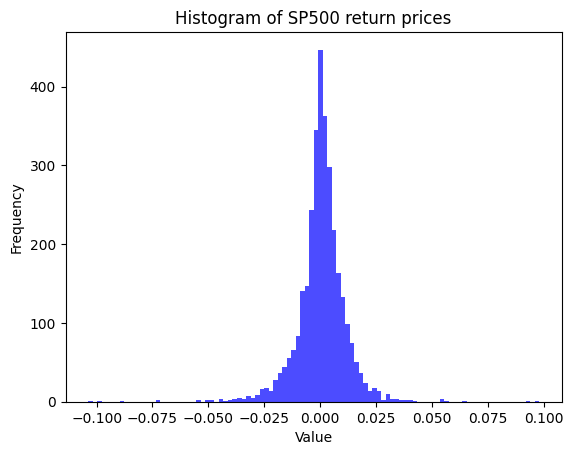

In [29]:
df_stationary['Close'].hist(bins=100, grid=False, color='blue', alpha=0.7)
plt.title('Histogram of SP500 return prices')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Split data to train and test


In [30]:
# first 80% of df is training set -> rest of it will be test set
train_set, test_set= np.split(df_stationary, [int(0.80 *len(df_stationary))])


 Now set our targets based on train set

In [31]:
first_quantile = train_set['Close'].quantile(0.25) # significant down move
last_quantile = train_set['Close'].quantile(0.75) # significant upper move

In [32]:
first_quantile

-0.0034431884659929524

In [33]:
last_quantile

0.005346901904835222

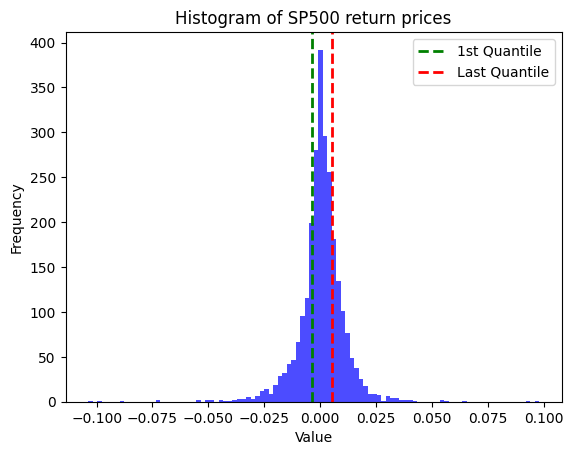

In [34]:
train_set['Close'].hist(bins=100, grid=False, color='blue', alpha=0.7)
plt.axvline(first_quantile, color='green', linestyle='dashed', linewidth=2, label='1st Quantile')
plt.axvline(last_quantile, color='red', linestyle='dashed', linewidth=2, label='Last Quantile')
plt.title('Histogram of SP500 return prices')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Everything from green line to left, and from red line to right is considered to be significant movement.

## Setting targets

In [35]:
#creating target column
# (0 -> no deal)
# (1-> short)
# (2 -> long)

train_set['Target'] = np.where(train_set['Close'] <= first_quantile, 1,
                        np.where(train_set['Close'] >= last_quantile, 2, 0))
#target is based on next day value, so we need to shift it
train_set['Target'] = train_set['Target'].shift(-1)
# dropping NaN from the entire DataFrame
train_set.dropna(inplace=True) # droping NaN

#do the same on test set
test_set['Target'] = np.where(test_set['Close'] <= first_quantile, 1,
                        np.where(test_set['Close'] >= last_quantile, 2, 0))

test_set['Target'] = test_set['Target'].shift(-1)

test_set.dropna(inplace=True) # droping NaN

The closing price is the last price of the day (session). This means that for instruments for which the session has not ended, the price will be determined based on the last price. Since it will be possible to determine the rate of return only after the end of the day, the last row of test data should be removed, since the prediction is created on the basis of the "virtual closing price"

In [36]:
#droping last row of test set
test_set.drop(test_set.tail(1).index,inplace = True)

In [37]:
X_train = train_set.drop(columns={'Target'})
y_train = train_set['Target']

X_test = test_set.drop(columns={'Target'})
y_test = test_set['Target']

## Creating Pipeline

Because of the large number of columns, I will use the unsupervised learning method - PCA - to find 90% of variance in training set. I need to first use StandardScaler. After PCA, I want to find best model using GridSearchCV (I will use XGB and Random Forest Classifier). There is why I'm going to create Pipeline.

In [38]:
# scaler, PCA, GridSearch
pipeline = Pipeline([
    ("preprocessing", StandardScaler()),
    ("PCA", PCA(0.9)),
    ("classifier", RandomForestClassifier())
])

# define parameter grid
param_grid = [{
    'classifier' : [XGBClassifier()],
    'classifier__objective':['multi:softprob','multi:softmax'],
    'classifier__learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3, 0.5],
    'classifier__max_depth': [1,2,3,5,6],
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__tree_method':['gpu_hist'],
},
{
    'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}]

clf = GridSearchCV(pipeline, param_grid, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best model
best_classifier = best_model.best_estimator_.get_params()['classifier']
print('Best Classifier:', best_classifier)

Best Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [39]:
y_pred_grid = best_model.predict(X_test)

In [43]:
def print_metrics(y_true, y_pred, classifier_name):
    print(classifier_name)
    print("Precision:", precision_score(y_true, y_pred_grid,average='weighted'))
    print("Recall:", recall_score(y_true, y_pred_grid,average='weighted'))
    print("F1-score:", f1_score(y_true, y_pred_grid,average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_grid))

In [44]:
print_metrics(y_test, y_pred_grid, "XGB Classifier")

XGB Classifier
Precision: 0.38133708741231
Recall: 0.4110429447852761
F1-score: 0.3475471221032597
Confusion Matrix:
 [[187  10  50]
 [122  11  78]
 [112  12  70]]


Looking at confusion matrix I can say, that model is good in predicting when to not to trade. Which can be helpful, but goal is to properly predict when to sell or buy.

## Conclusion

Assuming that all the data is already in the price and with the help of technical analysis alone you can predict significant movements of asset is wrong. There are a number of factors influencing investors behavior that go beyond historical movements.

Of course, the project does not exclude the possibility of effective use of this type of analysis. A considerable limitation, and the disadvantage of the approach used, was the setting of the target as a significant upward or downward movement of the next day.

It is possible that a study focused on whether there would be a significant movement within 'x' days could have proved much more accurate. Nevertheless, in such a case there would have been a risk of adjusting the approach to suit the expected result, which is a crucial mistake.